<a href="https://colab.research.google.com/github/mariusel991/UPT/blob/main/PI/Lab/LAB2" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms

# `ToTensor()` converts the image data from PIL type to 32-bit floating point
# tensors. It also divides all numbers by 255, so that all pixel values are between
# 0 and 1
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(
    root="../data", train=False, transform=trans, download=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 144217893.62it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 25100641.07it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 70566720.03it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4126170.41it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
len(mnist_train), len(mnist_test)

def get_fashion_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    plt.tight_layout()
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

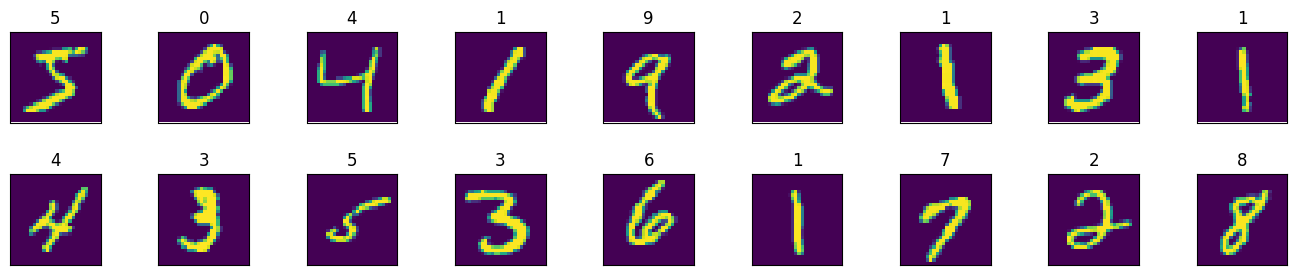

In [ ]:
X, y = next(iter(torch.utils.data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [ ]:
batch_size = 100

# Use 2 processes to read the data.
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=2)

In [ ]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size, resize=28)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([100, 1, 28, 28]) torch.float32 torch.Size([100]) torch.int64


In [ ]:
from torch import nn

# PyTorch does not implicitly reshape the inputs. Thus, we define the flatten
# layer to reshape the inputs before the linear layer in our network.
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
loss = nn.CrossEntropyLoss()
lr = 0.15
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [ ]:
def train_epoch(net, train_iter, loss, optimizer):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100


def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

In [ ]:
def train(net, train_iter, val_iter, loss, num_epochs, optimizer):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

In [ ]:
num_epochs = 15
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch 1, Train loss 0.50, Train accuracy 87.28, Validation loss 0.37, Validation accuracy 89.80
Epoch 2, Train loss 0.35, Train accuracy 90.44, Validation loss 0.34, Validation accuracy 90.46
Epoch 3, Train loss 0.32, Train accuracy 90.99, Validation loss 0.33, Validation accuracy 90.69
Epoch 4, Train loss 0.31, Train accuracy 91.51, Validation loss 0.32, Validation accuracy 90.86
Epoch 5, Train loss 0.30, Train accuracy 91.67, Validation loss 0.31, Validation accuracy 91.15
Epoch 6, Train loss 0.29, Train accuracy 91.86, Validation loss 0.31, Validation accuracy 91.20
Epoch 7, Train loss 0.29, Train accuracy 91.95, Validation loss 0.31, Validation accuracy 91.52
Epoch 8, Train loss 0.28, Train accuracy 92.12, Validation loss 0.30, Validation accuracy 91.38
Epoch 9, Train loss 0.28, Train accuracy 92.14, Validation loss 0.31, Validation accuracy 91.50
Epoch 10, Train loss 0.28, Train accuracy 92.29, Validation loss 0.30, Validation accuracy 91.62


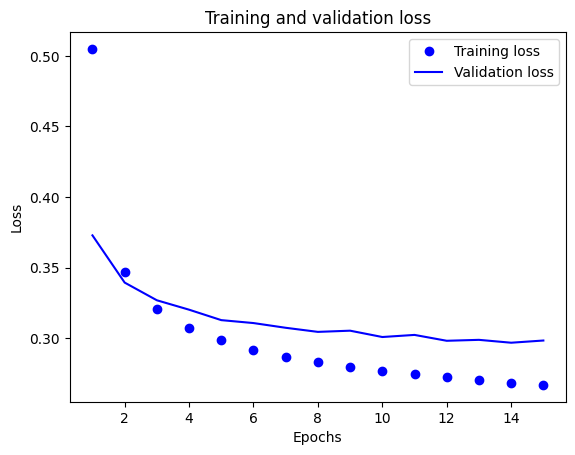

In [13]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1)
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(train_loss_all, val_loss_all)

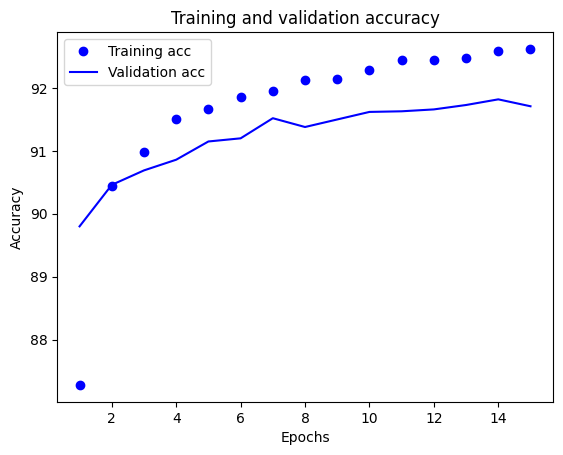

In [14]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(train_acc_all, val_acc_all)

In [15]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 0.27, Test accuracy 92.23


RESULTS!!!

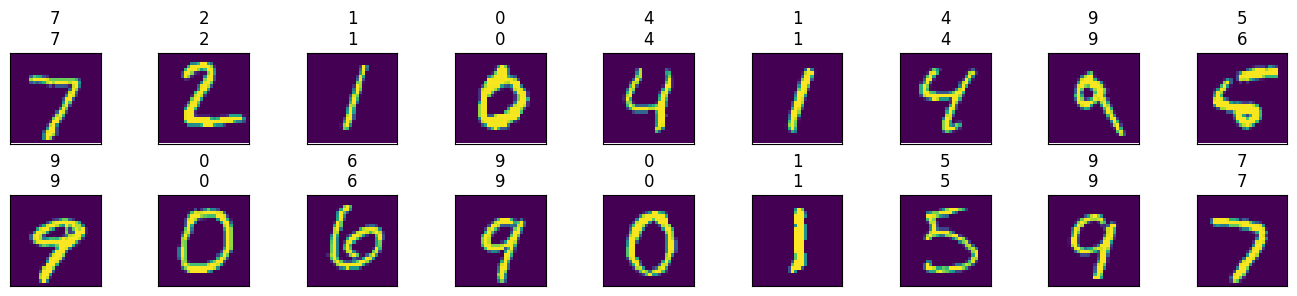

In [16]:
def predict(net, test_iter, n=18):
    """Predict labels."""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 2, int(n/2), titles=titles[0:n])

predict(net, test_iter)